In [ ]:
#pip install -qqq bitsandbytes torch transformers peft accelerate datasets loralib einops trl evaluate matplotlib tensorboard

from transformers import AutoModelForSeq2SeqLM
import torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import evaluate
from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import matplotlib.pyplot as plt
from transformers import DataCollatorForLanguageModeling
from datasets import load_dataset
from datasets import DatasetDict
import os
from utils import prepare_prompt



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [4]:
max_length = 2500

IDEE A DEV:
-lire papiers de recherches
-Tester modele encodeur decodeur

# Dataset Splitting

In [5]:
dataset_raw = load_dataset('json', data_files='dataset_llm_generated.json')


In [6]:
dataset = dataset_raw.select_columns(["text", "summary"])

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 5000
    })
})


Text(0.5, 1.0, 'Distibution')

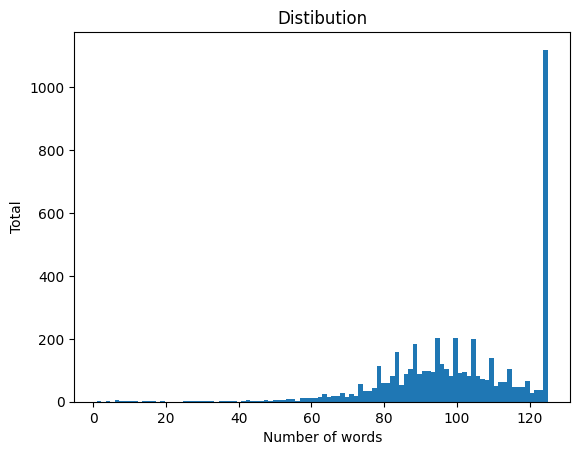

In [7]:
def get_num_word(example):
    return {"num_word": len(example["summary"].split())}

dataset_num_word = dataset['train'].map(get_num_word)

plt.hist(dataset_num_word["num_word"], bins=100)
plt.xlabel("Number of words")
plt.ylabel("Total")
plt.title("Distibution")

In [8]:
slm_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer_slm = AutoTokenizer.from_pretrained(slm_name, cache_dir="/Data/gabriel-mercier/slm_models")
tokenizer_slm.pad_token = tokenizer_slm.eos_token

In [9]:
summary_num_tokens = 200

def preprocess_data(examples):
    inputs = tokenizer_slm(examples["text"], truncation=True, max_length=max_length)
    targets = tokenizer_slm(examples["summary"], truncation=True, max_length=summary_num_tokens)
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_datasets = dataset.map(preprocess_data, batched=True)
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})


In [10]:
split_train_temp = tokenized_datasets["train"].train_test_split(test_size=0.4, seed=42)

split_valid_test = split_train_temp["test"].train_test_split(test_size=0.5, seed=42)

dataset_split = DatasetDict({
    "train": split_train_temp["train"],        
    "validation": split_valid_test["train"],      
    "test": split_valid_test["test"]              
})

print(dataset_split)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})


# Model Fine-Tuning

In [11]:
import sys
sys.executable

'/users/eleves-b/2022/ayoub.melliti/LLM project/.venv/bin/python'

In [12]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True, 
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_quant_type='nf4',
                            )
model_raw = AutoModelForCausalLM.from_pretrained(
    slm_name,
    cache_dir="/Data/gabriel-mercier/slm_models",
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map="auto"   
)


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [13]:
print(model_raw)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (

In [14]:
#lora_alpha = 2 * rank
attn_modules = ["q_proj", "k_proj", "v_proj", "o_proj"]
mlp_modules = ["up_proj", "down_proj", "gate_proj"]

lora_config = LoraConfig(r=16, 
                         lora_alpha=32,
                         target_modules=attn_modules,
                         lora_dropout=0.05,
                         bias='none',
                         task_type="CAUSAL_LM")

model = get_peft_model(model_raw, lora_config)
device = "cuda:0"
model = model.to(device)
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Line

In [15]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 2162688 || all params: 317282176 || trainable%: 0.6816292132338376


In [16]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer_slm.eos_token_id
generation_config.eos_token_id = tokenizer_slm.eos_token_id
generation_config.do_sample = True

### Example

In [17]:
summary_data = dataset_split['train'][1]['summary']
prompt = prepare_prompt(dataset_split['train'][1], summary_included=False)
print(prompt)

Résume précisément le texte suivant en français en 100 mots maximum. Concentre-toi sur les points essentiels sans ajouter d'opinions ni de commentaires. Évite les phrases inutiles et reformule les idées clairement.

Texte :
Troy Davis est présenté par de nombreuses personnalités comme le prototype du Noir innocent, condamné à mort pour le meurtre d'un policier blanc en 1989. AP/Thibault Camus Plus de trois cent rassemblements ont été organisés vendredi 16 septembre aux Etats-Unis et dans le monde pour réclamer la clémence pour Troy Davis, un condamné à mort qui doit être exécuté mercredi, dont le sort est désormais entre les mains du comité des grâces de Géorgie. L'exécution de Troy Davis, symbole international de la lutte contre la peine de mort, a été programmée par injection létale mercredi à la prison de Jackson, malgré les doutes sur sa culpabilité. Le comité des grâces de Géorgie est appelé lundi à commuer ou non la peine capitale de Davis en prison à vie. Une pétition réunissant

In [18]:
assistant_start = "Résumé concis et structuré (100 mots maximum) :"

encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
prediction = tokenizer_slm.decode(outputs[0], skip_special_tokens=True)
start_index = prediction.find(assistant_start)
if start_index != -1:
    response_start = start_index + len(assistant_start)
else:
    response_start = 0 

print("=== GENERATED SUMMARY ===")
print(prediction[response_start:])
print(len(prediction[response_start:].split()))
print("=== LABEL SUMMARY ===")
print(summary_data)
print(len(summary_data.split()))

=== GENERATED SUMMARY ===
 
- Troy Davis, un Noir innocent condamné à mort pour le meurtre d'un policier blanc, est présenté par de nombreux témoins comme le protégé du Noir innocent, le Black Panther, et l'actrice Susan Sarandon.
- Les témoins ont également appris qu'il était accusé de crimes contre l'intégrité et d'avoir été considéré comme un suspect dangereux.
- Troisième étape : l'exécution de Troy Davis, symbolique de la lutte contre la peine de mort, a été programmée par injection létale au pénitencier de Jackson, malgré les doutes sur sa culpabilité.
- Un comité des grâces de Géorgie a été appelé lundi à commuer ou non la peine capitale de Davis en prison à vie.
- Une pétition réunissant plus de 663 000
120
=== LABEL SUMMARY ===
Troy Davis, condamné à mort pour le meurtre d'un policier en 1989, doit être exécuté malgré des doutes sur sa culpabilité. Des manifestations mondiales réclament sa clémence. Le sort de Davis, 42 ans, est entre les mains du comité des grâces de Géorgie.

In [19]:
def generate_and_tokenize_prompt(data_point):
    full_prompt = prepare_prompt(data_point)+tokenizer_slm.eos_token 
    #print(f"full_prompt {full_prompt}")
    tokenized_full_prompt = tokenizer_slm(full_prompt, return_tensors='pt')
    labels = tokenized_full_prompt.input_ids.clone() ## FILL THE GAP: create the labels first by cloning input_ids
    
    # prompt = full_prompt[:full_prompt.find("Résumé")] + "Résumé"
    
    assistant_token = tokenizer_slm("Résumé concis et structuré", return_tensors='pt')['input_ids'][0]
    T = tokenized_full_prompt['input_ids'].flatten()
    S = assistant_token.flatten()
    
    for i in range(len(T) - len(S) + 1):
        if torch.equal(T[i:i+len(S)], S):
            end_prompt_idx = i+len(S)   ## FILL THE GAP: get the index of the '<assistant>:' (or the equivalent token) in order to replace all but response tokens with -100
    labels[:, :end_prompt_idx] = -100
    

    return {
        'input_ids': tokenized_full_prompt.input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': tokenized_full_prompt.attention_mask.flatten(),
    }


In [20]:
dataset_train = dataset_split["train"].shuffle(seed=42).map(generate_and_tokenize_prompt)
dataset_val = dataset_split["validation"].shuffle(seed=42).map(generate_and_tokenize_prompt)

In [21]:
print(dataset_train[1]['text'])
print(dataset_train[1]['summary'])
print(dataset_train[1]['input_ids'])
print(dataset_train[1]['labels'])
print(dataset_train[1]['attention_mask'])

"L'amnistie aura lieu avant la visite du président [Thein Sein] en Inde" mercredi, a assuré un responsable briman, lundi. AP/Khin Maung Win La télévision d'Etat en Birmanie annonce, mardi 11 octobre, la libération de plus de 6 300 "prisonniers", sans préciser si des détenus politiques comptaient parmi les bénéficiaires mais alors que les annonces en ce sens se sont multipliées dans le pays ces derniers jours. Les premières libérations interviendront mercredi. La commission nationale pour les droits de l'homme, mise en place en septembre par le gouvernement, avait réclamé, quelques heures auparavant, dans un quotidien officiel la libération des "prisonniers de conscience" afin de répondre aux appels en ce sens de la communauté internationale. Dans une lettre ouverte publiée par le quotidien anglophone New Light of Myanmar, considéré comme le porte-parole du régime, la commission rappelle mardi que "le secrétaire général des Nations unies et un certain nombre de pays réclament la libérat

### Training

In [29]:
from transformers import DataCollatorForSeq2Seq
import transformers

training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=3,
    logging_steps=2,
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    max_steps=100,   
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to="tensorboard",
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer_slm, model=model),
)

model.config.use_cache = False
trainer.train()

/users/eleves-b/2022/ayoub.melliti/LLM project/.venv/lib64/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.59 GiB. GPU 0 has a total capacity of 23.54 GiB of which 81.38 MiB is free. Including non-PyTorch memory, this process has 22.88 GiB memory in use. Of the allocated memory 21.79 GiB is allocated by PyTorch, and 846.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Model Evaluation

In [ ]:
encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
prediction = tokenizer_slm.decode(outputs[0], skip_special_tokens=True)
response_start = prediction.find(assistant_start)


print("=== GENERATED SUMMARY ===")
print(prediction[response_start:])
print(len(prediction[response_start:].split()))
print("=== LABEL SUMMARY ===")
print(summary_data)
print(len(summary_data.split()))

=== GENERATED SUMMARY ===
Voici le résumé de 130 mots : 

Facebook continue d'enregistrer des informations sur ses utilisateurs après leur déconnexion, utilisant des cookies pour fournir du contenu personnalisé et améliorer son service. Ces cookies sont conservés sur le disque dur et peuvent être récupérés par Facebook même si l'utilisateur quitte le site. Cependant, selon Nik Cubrilovic, ces cookies ne sont pas utilisés pour espionner les internautes et sont utilisés pour personnaliser les pages de sites Web et améliorer le service. La conférence F8 de Mark Zuckerberg a souligné la possibilité de publier des informations sur le profil des utilisateurs, comme celle de Bull Mancuso, sur Facebook. Les cookies utilisés sont contrôlés par Facebook et ne permettent pas aux utilisateurs de modifier ces données. Cette nouvelle fonctionnalité pourrait entraîner des conséquences pour la privacy des utilisateurs. 

(150 mots)Human
135
=== LABEL SUMMARY ===
 Selon Nik Cubrilovic, spécialiste en s

In [ ]:
rouge = evaluate.load("rouge")
bert_score = evaluate.load("bertscore")


In [ ]:
def evaluate_model(model, dataset, set="test"):
    summaries = [data_point['summary'] for data_point in dataset[set]]
    predictions = []

    for data_point in dataset[set]:
        prompt = prepare_prompt(data_point, summary_included=False)
        encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
        with torch.inference_mode():
            output = model.generate(
                input_ids=encoding.input_ids,
                attention_mask=encoding.attention_mask,
                generation_config=generation_config,
            )
            
        prediction = tokenizer_slm.decode(output[0], skip_special_tokens=True)
        response_start = prediction.find(assistant_start)
        # print(f"response start {response_start}")
        predictions.append(prediction[response_start:])
    # print(f"predictions {predictions}")
    rouge_results = rouge.compute(predictions=predictions, references=summaries)
    bert_results = bert_score.compute(predictions=predictions, references=summaries, lang="fr")
    
    print(f"set = {set} : ROUGE Scores: {rouge_results} BERTScore: {bert_results}")

In [ ]:
evaluate_model(model, dataset_split)

set = test : ROUGE Scores: {'rouge1': np.float64(0.3972360494508656), 'rouge2': np.float64(0.12946286374612376), 'rougeL': np.float64(0.2062117850250687), 'rougeLsum': np.float64(0.2445120447934191)} BERTScore: {'precision': [0.6826847791671753, 0.6876481771469116, 0.7118455767631531, 0.7292723655700684, 0.733092188835144, 0.7235287427902222, 0.71564120054245, 0.7365008592605591, 0.7425682544708252, 0.7356541156768799, 0.7506924271583557, 0.6814379692077637, 0.7002245187759399, 0.7292063236236572, 0.7402533292770386, 0.7407881617546082, 0.7481139898300171, 0.7332062721252441, 0.6548534631729126, 0.7249160408973694], 'recall': [0.7127090692520142, 0.7098967432975769, 0.7354943156242371, 0.7482820749282837, 0.7252928018569946, 0.7332981824874878, 0.7482444047927856, 0.735686182975769, 0.7856603860855103, 0.7662780284881592, 0.7567068338394165, 0.674723207950592, 0.7263787984848022, 0.7296074032783508, 0.7705840468406677, 0.747780978679657, 0.7370654940605164, 0.7403802871704102, 0.679458

In [ ]:
model_raw = AutoModelForCausalLM.from_pretrained(
    slm_name,
    cache_dir="/Data/gabriel-mercier/slm_models",
)
model_raw.to(device)


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [ ]:
evaluate_model(model_raw, dataset_split)

set = test : ROUGE Scores: {'rouge1': np.float64(0.4105805212040625), 'rouge2': np.float64(0.13805869811222818), 'rougeL': np.float64(0.21424772375608542), 'rougeLsum': np.float64(0.24828295599987146)} BERTScore: {'precision': [0.668182373046875, 0.660563588142395, 0.7115554809570312, 0.7368109226226807, 0.7616187334060669, 0.7188488245010376, 0.7089061737060547, 0.709980845451355, 0.7649809718132019, 0.7887769937515259, 0.7439485192298889, 0.695293664932251, 0.7531929016113281, 0.7419340014457703, 0.7366881966590881, 0.7212579250335693, 0.7290598750114441, 0.7391754388809204, 0.7382654547691345, 0.7328371405601501], 'recall': [0.6786659955978394, 0.6991459131240845, 0.7447879314422607, 0.7568933963775635, 0.7630525827407837, 0.7352464199066162, 0.742567777633667, 0.7189084887504578, 0.7952483296394348, 0.7779242992401123, 0.74933922290802, 0.6804883480072021, 0.7704300284385681, 0.7515066862106323, 0.7383511066436768, 0.7343348264694214, 0.74338698387146, 0.7419833540916443, 0.7439934